# Test -1.2: PRISim and pyuvsim Comparison

Piyanat Kittiwisit, Steven Murray, and the HERA Validation Team

<h3 id="tocheading">Table of Contents</h3>
<div id="toc"></div>

{We recommend installing jupyter_contrib_nbextensions and enabling the Table of Contents(2) extension, at which point this section can be removed, as it will be generated automatically.  The simplest way of doing this is ``conda install -c conda-forge jupyter_contrib_nbextensions``. To enable the extension, either go to ``localhost:xxxx/nbextensions`` and switch it on, or use ``jupyter nbextension enable toc2/main``. You'll also need to switch on the option to "Add a Table of Contents cell at the top of the notebook". Then delet this and the following javascript cell. 

If you don't want to install this, then leave the heading and javascript here, and execute the JS cell right before submitting the notebook.
}

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Setup and Metadata

### Abstract

### Model

The `healvis` sky model consists of a Gaussian with a peak value of 1 Jy/pixel, FWHM of 20°, drawn onto a HEALPix map with Nside=128. The observation time covers 24 hours of LST with time steps of 10 minutes. Frequencies are 100 to 130MHz with 97.66kHz channel widths.

In order to run this sky model in `pyuvsim`, it needs to be converted to an equivalent set of point sources. `healvis` approximates a diffuse map as a set of point sources located at the pixel centers. The sky model is converted to a point source catalog by multiplying the pixel values by the pixel area and scaling by a conversion factor. This model is saved as an npz file to be loaded into `pyuvsim`.

Since `pyuvsim` cannot yet simulate sources with spectral structure, the `healvis` model is made with a flat spectrum.

The array layout is a 37 element hex with 14.6m spacing. Primary beams are Airy disk patterns with Diameter set to 14m.

### Imports

In [3]:
%matplotlib inline
from datetime import datetime

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from pyuvdata import UVData
import uvtools
import healpy as hp

mpl.rcParams['figure.figsize'] = [10, 8]

In [4]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

### Description

In [5]:
print("Last executed: %s"%str(datetime.now()))

Last executed: 2020-03-26 14:12:49.249877


{If you installed the ``jupyter_contrib_nbextensions``, then enable the "Python Markdown" extension, remove the line above, and keep the following line. Otherwise, remove the following line and keep the line above.}

Last executed: {str(datetime.now())}

- **Major Step Description:** {Insert standard description of major step}
- **Minor Variation Description:** {Insert standard description of minor step}
- **Pipelines Tested:** {Brief list of explicit pipelines tested in the notebook}
- **Criteria**:
  1. {Explicit Criterion for success 1}
  2. {Explicit Criterion for success 2}
  

### Summary

The results of this validation test, in reference to the outlined criteria, are
1. {Test results for criteria 1}
2. {Test results for criteria 2...}

{Brief notes on anything else interesting that was noted during testing}

### Software

HERA software used in this validation test, with associate git commit hash:

* {``pyuvdata``: `229e0beeb6ed`}
* {If you have the Python Markdown extension, you can do this: ``pyuvdata``: ``{pyuvdata.version.git_hash}``
* {``healvis`` : version 1.1.0, `6d736fc8da42d`
* {``pyuvsim`` : version 1.1.0, `da21d37048850`}

Versions of other software used in this validation test:

* {``numpy``: vx.x.x}
* {etc. (only list imported modules).}

### Data

The following paths reflect the exact locations of all data used in this test:

In [6]:
pyuvsim_vis_path = "./pyuvsim_ref/simulation_results/"
prisim_vis_path = "./prisim_ref2/"

### Declaration

In [7]:
def read_prisim(filepath):
    """Read PRISim simulation file and inverse antenna numbering.
    
    PRISim uses ant2 > ant1 for antenna numbering convernsion, 
    whereas pyuvsim uses ant1 > ant2. This function read the 
    PRISim simulation file (usually in *.uvfits) into a UVData 
    object and invert the antenna numbering.
    
    Parameters
    ----------
    filepath: str
        Path to prisim simulation file
    
    Returns
    -------
    out: UVData
        PRISim simulation in UVData object with antenna numbering
        inverted (ant1 > ant2) to match pyuvsim convention.
    
    """
    UV = UVData()
    UV.read(filepath)
#     UV.select(frequencies=UV.freq_array[0][1])
    inds = np.where(UV.ant_2_array > UV.ant_1_array)
    UV.uvw_array[inds] *= (-1)
    UV.data_array[inds] = np.conj(UV.data_array[inds])
    dummy_1 = UV.ant_1_array[inds] 
    dummy_2 = UV.ant_2_array[inds] 
    UV.ant_1_array[inds] = dummy_2
    UV.ant_2_array[inds] = dummy_1
    UV.baseline_array = UV.antnums_to_baseline(UV.ant_1_array, UV.ant_2_array)
    return UV

## Reference 1.1

Get file paths for reference 1.1

In [8]:
ref1_pyuvsim_path = pyuvsim_vis_path + "/ref_1.1_uniform.uvfits"
ref1_prisim_path = prisim_vis_path + "/1.1e/simdata/all-simvis-noiseless.uvfits"

Read `pyuvsim` simulation

In [9]:
ref1_pyuvsim_data = UVData()
ref1_pyuvsim_data.read(ref1_pyuvsim_path)

Read `PRISim` simulation

In [10]:
# ref1_prisim_data = UVData()
# ref1_prisim_data.read(ref1_prisim_path)
ref1_prisim_data = read_prisim(ref1_prisim_path)

Telescope custom is not in known_telescopes.


### Metadata Checking
A few issues with the reference simulation
* PRISim and pyuvsim reference simulations have different anttena reference numbers.
* PRISim simulation has no `telescope_name` but `telescope_location` shows correct locations - so this should not post an issue.
* PRISim simulation has two frequency channels and one polarization (xx), whereas pyuvsim simulation has full polarization and one frequency channel.
* pyuvsim has 3916 correlated baselines with 88 antennas, not sure where the extra baselines come from.
* **Data will have to be selected for comparison.**

In [11]:
print('dataarray.shape =', ref1_prisim_data.data_array.shape)
print('ants =', ref1_prisim_data.get_ants())
print('baseline_nums =', ref1_prisim_data.get_baseline_nums())
print('pols =', ref1_prisim_data.get_pols())
print('telescope_name =', ref1_prisim_data.telescope_name)
print('telescope_location =', ref1_prisim_data.telescope_location)
# ref1_prisim_data.telescope_name = "MWA"
# ref1_prisim_data.set_telescope_params()
print('Nants_data =', ref1_prisim_data.Nants_data)
print('Nants_telescope =', ref1_prisim_data.Nants_telescope)
print('Nbls =', ref1_prisim_data.Nbls)
print('Nblts =', ref1_prisim_data.Nblts)
print('Nfreqs =', ref1_prisim_data.Nfreqs)
print('freq_array =', ref1_prisim_data.freq_array)

dataarray.shape = (3828, 1, 2, 1)
ants = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87]
baseline_nums = [ 69633  71681  71682 ... 245845 245846 245847]
pols = ['xx']
telescope_name = custom
telescope_location = [ 5109342.76037543  2005241.90402741 -3239939.46926405]
Nants_data = 88
Nants_telescope = 88
Nbls = 3828
Nblts = 3828
Nfreqs = 2
freq_array = [[9.992e+07 1.000e+08]]


In [12]:
print('dataarray.shape =', ref1_pyuvsim_data.data_array.shape)
print('ants =', ref1_pyuvsim_data.get_ants())
print('baseline_nums =', ref1_pyuvsim_data.get_baseline_nums())
print('pols =', ref1_pyuvsim_data.get_pols())
print('telescope_name =', ref1_pyuvsim_data.telescope_name)
print('telescope_location =', ref1_pyuvsim_data.telescope_location)
print('Nants_data =', ref1_pyuvsim_data.Nants_data)
print('Nants_telescope =', ref1_pyuvsim_data.Nants_telescope)
print('Nbls =', ref1_pyuvsim_data.Nbls)
print('Nblts =', ref1_pyuvsim_data.Nblts)
print('Nfreqs =', ref1_pyuvsim_data.Nfreqs)
print('freq_array =', ref1_pyuvsim_data.freq_array)

dataarray.shape = (3916, 1, 1, 4)
ants = [ 40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127]
baseline_nums = [149545 151593 151594 ... 327806 327807 327808]
pols = ['xx', 'yy', 'xy', 'yx']
telescope_name = MWA
telescope_location = [ 5109342.76037543  2005241.90402741 -3239939.46926405]
Nants_data = 88
Nants_telescope = 88
Nbls = 3916
Nblts = 3916
Nfreqs = 1
freq_array = [[1.e+08]]


### Antenna Positions
With the missmatching antenna reference numbers, it is wise to first plot and compare the antenna positions from the two simulations

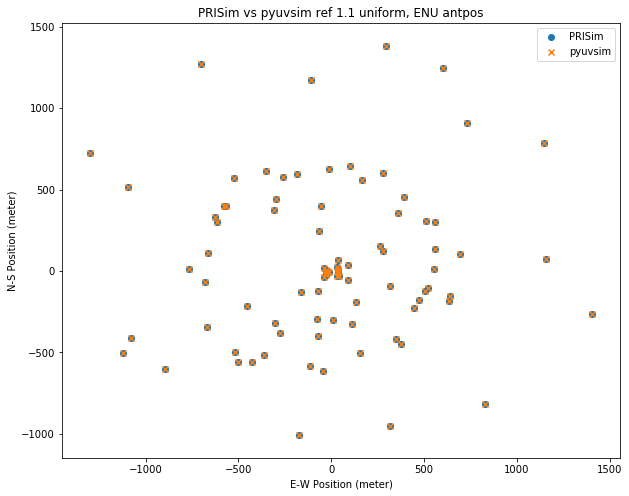

In [13]:
prisim_antpos, prisim_ants = ref1_prisim_data.get_ENU_antpos()
pyuvsim_antpos, pyuvsim_ants = ref1_pyuvsim_data.get_ENU_antpos()
plt.figure()
plt.scatter(prisim_antpos[:, 1], prisim_antpos[:, 0], marker='o', label='PRISim')
plt.scatter(pyuvsim_antpos[:, 1], pyuvsim_antpos[:, 0], marker='x', label='pyuvsim')
plt.xlabel('E-W Position (meter)')
plt.ylabel('N-S Position (meter)')
plt.legend()
plt.title('PRISim vs pyuvsim ref 1.1 uniform, ENU antpos')
plt.savefig('ref1.1_uniform_ENU_antpos.pdf')
plt.show()

### Data Selection

In [14]:
# ref1_prisim_data.antenna_numbers = ref1_pyuvsim_data.antenna_numbers
# ref1_prisim_data.set_telescope_params()

In [15]:
ref1_prisim_data_selected = ref1_prisim_data.select(
    frequencies=ref1_prisim_data.freq_array[0, 1], inplace=False
)

In [16]:
# ref1_prisim_data2_selected = ref1_prisim_data2.select(
#     frequencies=ref1_prisim_data.freq_array[0, 1], inplace=False
# )

In [17]:
ref1_pyuvsim_data_selected = ref1_pyuvsim_data.select(ant_str='cross', inplace=False)

### UV Diff Plot

invalid value encountered in less_equal
invalid value encountered in less_equal


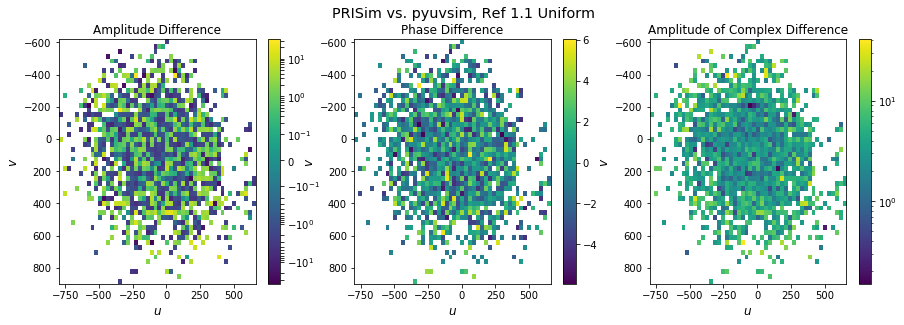

In [18]:
fig = uvtools.plot.plot_diff_uv(
    ref1_pyuvsim_data_selected, ref1_prisim_data_selected, check_metadata=False, pol='xx'
)
fig.suptitle('PRISim vs. pyuvsim, Ref 1.1 Uniform', fontsize='x-large')
fig.savefig('ref1.1_uniform_diff_uv_plot.pdf')

## Reference 1.2

In [19]:
ref2_pyuvsim_path = pyuvsim_vis_path + "/ref_1.2_gauss.uvfits"
ref2_prisim_path = prisim_vis_path + "1.2_gauss/simdata/all-simvis-noiseless.uvfits"

In [20]:
ref2_pyuvsim_data = UVData()
ref2_pyuvsim_data.read(ref2_pyuvsim_path)

Telescope BLLITE is not in known_telescopes.


In [21]:
ref2_prisim_data = UVData()
ref2_prisim_data.read(ref2_prisim_path)

FileNotFoundError: [Errno 2] No such file or directory: './prisim_ref2/1.2_gauss/simdata/all-simvis-noiseless.uvfits'

Ongoing issues
* PRISim simulations for 1.2_uniform 1.2_gauss, and 1.3_hera are missing
* Missmatching antenna position and antenna reference numbers between PRISim and pyuvsim

In [ ]:
UV.get_ants()